In [2]:

import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.utils import calc_total_error
import pandas as pd
from scipy.spatial import KDTree
import json


from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [3]:
%matplotlib inline

# running over all galaxies

In [59]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask

def overlap_area(radius, distance):
    Area = ((2 * radius**2) * np.arccos((distance / (2 * radius)))) - ( .5 * distance * np.sqrt( (4 * radius**2) - distance**2))
    return Area



# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE', 'NET_LUM_APER_0.3-8.0', 'Hard_Flux_Color' , 'Soft_Flux_Color']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE', 'NET_LUM_APER_0.3-8.0', 'Hard_Flux_Color' , 'Soft_Flux_Color']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values, 
                                 'NET_LUM_APER_0.3-8.0': group['NET_LUM_APER_0.3-8.0'].values,  'Hard_Flux_Color': group['Hard_Flux_Color'].values , 'Soft_Flux_Color': group['Soft_Flux_Color'].values }
  



rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[0:5]



# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
#print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals.itertuples():
    galaxy_name = galaxy.source_id
    #print(galaxy_name)
    #group = aligned_aggregatedsources.get_group(galaxy_name)
  
    # Print galaxy information
    #print(f"\nGalaxy: {galaxy_name}")
    #print(group)


    #define coordinates
    ra1 = galaxy.ra_x
    #print (ra1)
    dec1 = galaxy.dec_x
    pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
    #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
    im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
    #im_table
    im_table.to_table().colnames
    #print(im_table)
    # get the Ra and dec values necessary for the kdtree and rest of the code
    if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       NET_LUM_APER_all = galaxy_sources[galaxy_name]['NET_LUM_APER_0.3-8.0']
       Hard_Flux_Color = galaxy_sources[galaxy_name]['Hard_Flux_Color']
       Soft_Flux_Color = galaxy_sources[galaxy_name]['Soft_Flux_Color']
       print(f"Galaxy: {galaxy_name}")
       #print("RA values:", ra)
       #print("Number of RA values:", len(ra))
    else:
       print(f"No sources found for galaxy: {galaxy_name}")
       continue # skip to the next galaxy if no sources were found
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1

    for i in [0, 3, 2, 1]:  # Reverse order index
        band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
        if band_id in band_labels:
            #print(f'Band {band_labels[band_id]}: ')
            data_url = im_table[i].getdataurl()
            #Download the image and open it in Astropy
            fname = download_file(data_url, cache=True)
            image1= fits.open(fname)
            image_data= image1[0].data
            #print(data)
            #print(data_url)
            wcs = WCS(image1[0].header)
            #cuting out the image of the galaxy apart from the rest of the background.
            cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
            wcs = cutout.wcs
            cutout_data = cutout.data
            #print(cutout_data)
            positions = wcs.world_to_pixel_values(ra, dec)
            positions = np.array(list(zip(positions[0], positions[1])))


            #define the distance threshold for the KDTree grouping (in pixels)
            distance_threshold = 5


            #build the KDTree for efficient grouping
            tree = KDTree(positions)


            #query the KDTree to find points within the defined radius of dist threshold and group them together
            groups = tree.query_ball_tree(tree, r=distance_threshold)
            # print(groups)
            # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
            unique_groups = []
            seen = set()
            for group in groups:
                group = tuple(sorted(group))
                if group not in seen:
                    seen.add(group)
                    unique_groups.append(group)
                 # print(unique_groups)
            # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
             #represents the consolidated postion of potentially multiple detections of one source.
            grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
            #print(grouped_positions)

            #print("Grouped positions for galaxy", galaxy_name, ":", grouped_positions)
            #define the Region(s) Of Interest (center x, center y, radius)
            ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping?
          


                # initialize valid rows plotting for the current image iteration
            valid_rows = []
           
           #now inputting the aperture photometry part
           # check for overlap and perform aperture photometry
            for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
                overlap_dict = []
                overlap = False # initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source. becomes true if they do overlap 
                acc_overlap = False # initialize the acceptable overlap flag.  false if there is no overlap, true if there is overlap and it is acceptable 
               

                for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                    if i != j: # ensures that a source is not compared to itself! wow
                        #print(f'{x}, {y} / {x2}, {y2}')
                        #print(f"Checking positions: ({x}, {y}) and ({x2, {y2}})")
                        distance = dist((x, y) , (x2, y2))
                        #print(f"Distance: {distance}, Radii Sum: {r + r2}")
                        #print('dsitance', distance)
                        #print('Distance', distance)
                        #print('r1', r)
                        if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                            #print(distance)
                            #print('yesif')
                            overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                            #print('overlap perc', overlap_percent)
                            if overlap_percent > .5:
                                overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                                #print('overlap is unacceptable: ', overlap)
                                overlap_aperture = np.nan
                                overlap_photo_table = np.nan
                                overlap_counts = np.nan
                                overlap_error = np.nan
                              
                            elif overlap_percent <= .5:
                                acc_overlap = True
                                #print('acceptable or no overlap: ', acc_overlap)
                                #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                                overlap_aperture = CircularAperture((x2, y2), r2)
                                overlapping_area = overlap_area(r,distance) # using the function to define the overlapping area for the location of overlap
                                overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                                total_area = math.pi * r**2
                                overlap_counts = overlap_photo_table['aperture_sum'][0] * ( overlapping_area/total_area ) # scaling the counts by the overlapping area
                                overlap_error = np.sqrt(overlap_counts)
                                overlap_dict.append({'Position': ({x}, {y}),  'overlapping counts': overlap_counts, 'overlap_error': overlap_error})
                                #print('were here')
                                #print('Overlap counts', overlap_counts)
                                #print('overlapdict', overlap_dict)



                        else:
                            #print(' Prob skips distance if statement')
                            #print('not overlapping at all')
                            overlap_percent = np.nan
                            overlap_aperture = np.nan
                            overlap_photo_table = np.nan
                            overlap_counts = np.nan
                            overlap_error = np.nan

                       
                #print(acc_overlap)  
                if acc_overlap:
                    overlap_counts = 0
                    overlap_error = 0
                    # for a source, if it overlaps with more than one other source, add all of the counts for those overlapping regions
                    for row in overlap_dict:
                        if not np.isnan(row['overlapping counts']) and not np.isnan(row['overlap_error']):
                            overlap_counts += row['overlapping counts'] # now add in quadriture for the propagation of error for sources like this
                            overlap_error += row['overlap_error']**2
                    overlap_error= np.sqrt(overlap_error)
                    #print('Overlapping COUNTS HERE', overlap_counts)
                    # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
                   
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]

                    target_counts -= overlap_counts
                    # so that i dont take the log or sqrt of a negative number or zero and get an error
                    if target_counts > 0: #
                        target_error= np.sqrt(target_counts)
                        #propagated error of overlap error
                        target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                        #print(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                          
                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:# to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        target_error = np.nan
                        target_overlap_counts_err = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                    # continuing on with the photometry under the "if acc_overlap"


                    #calculate area of target aperutue
                    target_area = target_aperture.area

                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                  
              
                    if annulus_counts > 0:
                        overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                        # to avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)




                    else: 
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        overlapannulus_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
              
                    #flag the sources that overlap
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'NET_LUM_APER_0.3-8.0' : NET_LUM_APER_all[i], 'Hard_Flux_Color' : Hard_Flux_Color[i], 'Soft_Flux_Color' : Soft_Flux_Color[i], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all', 'Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]},  'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'NET_LUM_APER_0.3-8.0' : NET_LUM_APER_all[i], 'Hard_Flux_Color' : Hard_Flux_Color[i], 'Soft_Flux_Color' : Soft_Flux_Color[i],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                       'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                  
                else: #perform all the normal aperture photometry stuff for those that do not overlap in any way.
            
                   # For the Target objects in the little aperture circle define their target apertures
                    target_aperture = CircularAperture((x,y),r,)
              
                    #perform aperture photometry on target
                    target_photo_table = aperture_photometry(cutout_data, target_aperture)
                    target_counts = target_photo_table['aperture_sum'][0]


                    if target_counts > 0:   # avoid taking the log of zero or negative value
                        target_error = np.sqrt(target_counts)
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                            target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                    else:
                        target_error = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                      
                    #calculate area of target aperutue
                    target_area = target_aperture.area




                    # For the Background Annuli of outside of the Target
                    #define the background annulus for the target
                    annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                    #perform aperture photometry on annuli
                    annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                    annulus_counts = annulus_photo_table['aperture_sum'][0]
                    # the error of the annulus for sources that overlap
                  
                    if annulus_counts > 0:
                        annulus_error = np.sqrt(annulus_counts)
                        # avoid taking the log of zero or negative value
                        if band_id in flux_zmfd and instr_zpmag:
                            #print(f'Band {flux_zmfd[band_id]}: ')
                            flx_conv_fact = flux_zmfd[band_id]
                            M0instr = instr_zpmag[band_id]
                            Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                            annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                            #propagation of uncertainty of flux conversion
                            Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                            annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                    else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        annulus_error = np.nan
                        annulus_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                    #calculate area of annulus
                    annulus_area = annulus_aperture.area


                    # do the calculations for including a Background aperture
              
                    #Calculating the net flux:
                    #calculate the mean background per pixel
                    bg_perpixel = annulus_flux/annulus_area
                    bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                    #calculate the total background in the target aperture
                    tot_bg = bg_perpixel * target_area
                    tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                    #Subtract background from the target flux
                    net_flx = target_flux - tot_bg
                    net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                    if overlap:
                        overlap_counts = np.nan
                        overlap_error = np.nan
                        target_counts = np.nan

                    #   Append the result as a dictionary to the list named 'rows'
                    rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'NET_LUM_APER_0.3-8.0' : NET_LUM_APER_all[i], 'Hard_Flux_Color' : Hard_Flux_Color[i], 'Soft_Flux_Color' : Soft_Flux_Color[i], 
                                 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,
                                   'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux, 'Acceptable overlapping?': 'Yes' if acc_overlap == True else 'Not acceptable or no overlap at all','Unacceptable overlapping?': 'Yes' if overlap == True else 'Acceptable or no overlap at all',
                               'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
                        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
              
                    # Append valid results to valid_rows
                    valid_rows.append({
                       'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'NET_LUM_APER_0.3-8.0' : NET_LUM_APER_all[i], 'Hard_Flux_Color' : Hard_Flux_Color[i], 'Soft_Flux_Color' : Soft_Flux_Color[i],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                       'Flag':'Valid' if not np.isnan(np.array(target_counts)) and target_counts > 0 and net_flx > 0 else 'Nan values or Low Flux',
                       'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                       'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })




            #Source detection code
            mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0) 
            #print((mean, median, std))


            # subtract the background and find FWHM of sources at a certain threshold
            #started at fwhm= 3 and threshold = 5
            daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background.
            sources = daofind(cutout_data - median) 
            #print(type(sources))
            # will likely run into iissues in the code below
            for col in sources.colnames: 
                if col not in ('id', 'npix'):
                    sources[col].info.format = '%.2f'  # for consistent table output
                        # sources.pprint(max_width=3000) 


                        #likely the flux labeled in this is not converted!
          
            # plot the image with marked locations of all the sources it detected.
            detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
            apertures = CircularAperture(detected_positions, r=2)




            # Plotting for current image
            # Filter valid rows
            valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
          
            # Was there a point source there?
            pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
            detectedpos_all = []
            #rows = [row for row in rows if row['Flag'] == 'Valid']
            for row in valid_rows_filtered:
                apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                for detected_position in detected_positions:
                    detected_x, detected_y = detected_position
                    distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                    if distance <= row['Radius']:
                        row['Exists?'] = 'Point Source Detected'
                        row['Point Source Position'].append((detected_x, detected_y))
                        dist_in_arc = distance * pixelsinarc
                        row['Offset in Arcseconds'].append((dist_in_arc))
                        detectedpos_all.append(detected_position)



            Yes = []
            YesRadius= 5
            for row in valid_rows_filtered:
                        apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                        for detected_position in detected_positions:
                            detected_x, detected_y = detected_position
                            distance = dist((row['X'], row['Y']), (detected_x, detected_y) )
                            if distance <= YesRadius:
                                row['Exists?'] = 'Yes!!'
                                Yes.append((row['X'], row['Y']))
                                #else: # this does not seem to do what i want it to do
                               #row['Exists?'] = 'Detected but does not exist'
                               
            #doing flux density
            for row in valid_rows_filtered:
                net_flx = row['Net Flux (Jy)']
                net_flx_err = row['Flux Uncertainty']
                wavelength = row['Wavelength']
                #print(net_flx)
                flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
                row['Flux Density'].append(flux_density)
                row['Flux Density Uncertainty'].append(flux_density_unc)
                  
          
            # Update rows with valid_rows_filtered information
            for valid_row in valid_rows_filtered:
                for row in rows:
                    if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                        row.update(valid_row)


            #print('valid sources', valid_rows_filtered)


            #print( len(detectedpos_all))
            if len(detectedpos_all) > 0:
                apertures_detected = CircularAperture(detectedpos_all, r=2)
            if len(Yes) > 0:
                apertures_Yes = CircularAperture(Yes, r=YesRadius)
          
         # xc = 244.422687    #19.014239
        # yc=  191.596758# 310.340772
      
                

           # Plotting for current image
            '''
            fig, ax = plt.subplots(subplot_kw={'projection': wcs})
            norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
            for row in valid_rows_filtered: # use 'valid_rows_filtered' to change it back to only the valid sources. use 'rows' to plot all sources
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
                annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
              
                apertures.plot(color='#98ff98', lw=.5, alpha=0.5)
                apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
                apertures_Yes.plot(color='green', lw=.5, alpha=0.5)


                # curious ones
            # curious = CircularAperture((xc,yc),5)
            # curious.plot(color='red', lw=.5, alpha=0.5)
            ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
            ax.set_xlabel('Right Ascension')
            ax.set_ylabel('Declination')
            plt.title(f'Band {band_labels[band_id]}')
            plt.show()
            yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
            #'''
   
           

  
  


           
      






display_data = pd.DataFrame(rows)
#by_name = display_data.groupby('Galaxy Name')
#byname = by_name.apply(lambda x: x).reset_index(drop=True)
#print("\n FINAL Sources Grouped by Galaxy:")
#display(byname)
#byname_byband = by_name.groupby('band_id')
#display(byname_byband)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)

print('Number of valid sources: ',len(display_data.loc[display_data['Flag']== 'Valid']))
print('Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once): ',len(display_data))
print('Number of sources coincidental with WISE bright points within 5 arcsec: ',len(display_data.loc[display_data['Exists?']== 'Yes!!']))
'''
print("\n all of the valid sources")
display(display_data.loc[display_data['Flag']== 'Valid'])
print("\n all of the Yes!! sources")
display(display_data.loc[display_data['Exists?']== 'Yes!!'])

display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))






  
#'''



/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_75616/753384322.py:50: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


Galaxy: NGC 5128
Galaxy: MESSIER 106
Galaxy: MESSIER 051
Galaxy: MESSIER 082


Galaxy: NGC 1569
Galaxy: NGC 0253


Galaxy: NGC 0891
Galaxy: NGC 1291:[LFF2012] 084
Galaxy: NGC 4631
Galaxy: MESSIER 094
Galaxy: NGC 4945
No sources found for galaxy: UGC 06456
Galaxy: NGC 6503
No sources found for galaxy: NGC 4395
Galaxy: NGC 4244
No sources found for galaxy: NGC 4111
Galaxy: NGC 4485
Galaxy: MESSIER 105
Galaxy: NGC 2403
Galaxy: MESSIER 108
Galaxy: NGC 5253
Galaxy: MESSIER 074
Galaxy: ESO 495- G 021
Galaxy: MESSIER 063
No sources found for galaxy: NGC 7331
Galaxy: NGC 5102
Galaxy: NGC 4725
Galaxy: NGC 4526
Galaxy: NGC 1705
Galaxy: NGC 7793
Galaxy: NGC 4473
Galaxy: NGC 2787
Galaxy: NGC 0045
Galaxy: NGC 1023


In [20]:
#FOR SOURCES COINCIDENT WITH XRAY

# convert the "set" tyoe of band_id to string :
# Convert the set values in 'band_id' to strings
exists =  display_data.loc[display_data['Exists?']== 'Yes!!']
exists['band_id'] = exists['band_id'].apply(lambda x: list(x)[0] if isinstance(x, set) else x)



exists =  exists.loc[display_data['Exists?']== 'Yes!!']
data_out = Table.from_pandas(exists)
output_path = '../Data/Hugefiles/forced_phot_YES1.csv'

# Write the table in csv format
data_out.write(output_path, format='csv')


/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_75616/1418055892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exists['band_id'] = exists['band_id'].apply(lambda x: list(x)[0] if isinstance(x, set) else x)


TypeError: unhashable type: 'list'

In [ ]:
# FOR ALL SOURCES
data_out = Table.from_pandas(display_data)
output_path = '../Data/Hugefiles/forced_phot_ALL1.csv'

# Write the table in csv format
data_out.write(output_path, format='csv')


# Color-Color Diagrams

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_75616/2048642274.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exists['band_id'] = exists['band_id'].apply(lambda x: list(x)[0] if isinstance(x, set) else x)


,band_id,Galaxy Name,ObsID,NET_LUM_APER_0.3-8.0,Hard_Flux_Color,Soft_Flux_Color,Region,X,Y,Radius,...,Offset in Arcseconds,Exists?,Point Source Position,Target Error,Annulus Error,Overlap Error (in counts),Wavelength,Flux Density,Flux Density Uncertainty,Overlap Counts
8,W4,MESSIER 106,1618,1.241346e+38,0.144571,-0.004535,9,354.085456,268.917862,9,...,[1.6336655815081136],Yes!!,"[(353.54594024392566, 267.8593003920052)]",0.009239,0.016957,[],22.0,[4.712241674506774e-11],[6.520511653763701e-10],7123.742023
20,W4,MESSIER 106,1618,6.624425e+37,0.514280,0.328051,21,297.004654,85.718981,9,...,[3.8587447470531946],Yes!!,"[(297.3450416611471, 88.50462169439736)]",0.009234,0.016951,[],22.0,[2.683520793256197e-11],[6.517683314640675e-10],915.371488
30,W4,MESSIER 106,1618,NaN,NaN,0.024854,31,263.370669,227.366562,9,...,"[2.4600695529639593, 10.19635966051896]",Yes!!,"[(265.15981053671555, 227.3672708879272), (257...",0.009280,0.017025,2.262561,22.0,[1.2311774001805182e-10],[6.54904868768665e-10],11600.505298
43,W4,MESSIER 051,13814,NaN,NaN,-0.127870,44,276.182830,135.780948,9,...,[5.602967746611121],Yes!!,"[(272.2161659485808, 136.71382827954235)]",0.009208,0.016529,10.05068,22.0,[3.952317408677615e-09],[6.466337897721471e-10],38522.809985
49,W4,MESSIER 051,13814,4.592139e+38,0.265215,-0.443132,50,258.518840,238.010099,9,...,[1.3937503201766634],Yes!!,"[(258.0096428700752, 238.8865557563635)]",0.009048,0.016530,[],22.0,[9.22447671984937e-10],[6.379501771102654e-10],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,W2,NGC 1569,782,7.370995e+36,0.661566,0.830005,48,219.792586,221.900179,9,...,"[2.7556242254552745, 6.986533452474968]",Yes!!,"[(220.58382864054963, 220.0588985221163), (224...",0.000365,0.000340,67.493974,4.6,[3.79662044147753e-08],[5.372566462231711e-10],4555.436504
2772,W2,NGC 1569,782,1.028721e+37,0.892385,NaN,49,216.594317,164.984954,9,...,[0.6975374938659852],Yes!!,"[(217.0895416470553, 165.09498132506113)]",0.000127,0.000204,[],4.6,[2.0590425404144184e-09],[1.9961774011069152e-10],NaN
2787,W2,NGC 1569,782,4.109796e+35,0.406948,0.567634,64,102.384183,231.279451,9,...,[0.27541187555625574],Yes!!,"[(102.19805940996791, 231.20543933646283)]",0.000205,0.000197,[],4.6,[1.669711604738269e-08],[3.0172530207988005e-10],NaN
2789,W2,NGC 1569,782,7.038753e+35,0.490005,0.926763,66,87.969102,175.068979,9,...,[0.1210260191980133],Yes!!,"[(87.90218487641295, 175.12615841746197)]",0.000191,0.000196,[],4.6,[1.3718860460305113e-08],[2.8276812656152826e-10],NaN


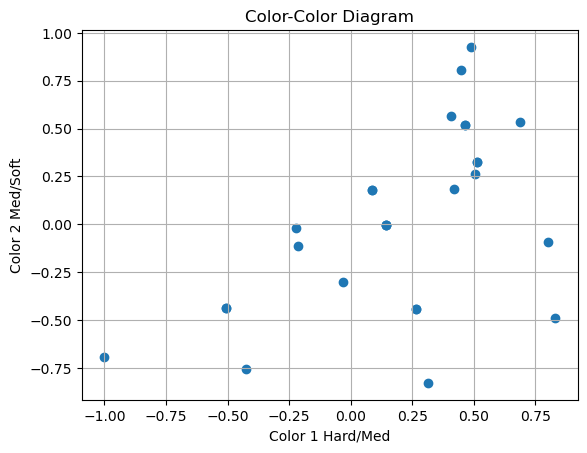

In [58]:
#exists = pd.read_csv('../Data/Hugefiles/forced_phot_YES.csv')
exists =  display_data.loc[display_data['Exists?']== 'Yes!!']
#display(exists)
# Convert the set values in 'band_id' to strings
exists['band_id'] = exists['band_id'].apply(lambda x: list(x)[0] if isinstance(x, set) else x)


display( exists)
# access flux for each band
fluxw1 = exists.loc[exists['band_id'] == 'W1', 'Net Flux (Jy)'].values
fluxw2 = exists.loc[exists['band_id'] == 'W2', 'Net Flux (Jy)'].values
fluxw3 = exists.loc[exists['band_id'] == 'W3', 'Net Flux (Jy)'].values
fluxw4 = exists.loc[exists['band_id'] == 'W4', 'Net Flux (Jy)'].values

'''
print("Flux W1:", fluxw1)
print("Flux W2:", fluxw2)
print("Flux W3:", fluxw3)
print("Flux W4:", fluxw4)
'''
#make sure all of the bands have the same length for their arrays since some fluxes are missing for some positions in each band.
min_length = min(len(fluxw1), len(fluxw2), len(fluxw3), len(fluxw4) )
fluxw1 = fluxw1[:min_length]
fluxw2 = fluxw2[:min_length]
fluxw3 = fluxw3[:min_length]
fluxw4 = fluxw4[:min_length]

H = exists['Hard_Flux_Color'].values
S = exists['Soft_Flux_Color'].values

# use the min length from the flux values cuz it should be the same length either way.
H = H[:min_length]
S = S[:min_length]




plt.scatter(H, S, marker = 'o')
plt.xlabel('Color 1 Hard/Med')
plt.ylabel('Color 2 Med/Soft')
plt.title('Color-Color Diagram')
plt.grid(True)
plt.show()


# Color- luminosity

#'''



In [ ]:
''' Color plpotting but it's not actually useful plots. 
print("Flux W1:", fluxw1)
print("Flux W2:", fluxw2)
print("Flux W3:", fluxw3)
print("Flux W4:", fluxw4)



color_1_2 = (fluxw1 - fluxw2) / (fluxw1 +fluxw2)
color_1_3 =(fluxw1 - fluxw3) / (fluxw1 +fluxw3)
color_1_4 =(fluxw1 - fluxw4) / (fluxw1 +fluxw4)
color_2_3 =(fluxw2 - fluxw3) / (fluxw2 +fluxw3)
color_2_4 =(fluxw2 - fluxw4) / (fluxw2 +fluxw4)
color_3_4 = (fluxw3 - fluxw4) / (fluxw3 +fluxw4)

print (color_1_2)
# should be 15 color pairs
color_pairs = [(color_1_2, color_1_3, 'W1-W2', 'W1-W3'), 
                (color_1_2, color_1_4, 'W1-W2', 'W1-W4'),
                (color_1_2, color_2_3, 'W1-W2', 'W2-W3'), 
                (color_1_2, color_2_4, 'W1-W2', 'W2-W4'), 
                (color_1_2, color_3_4, 'W1-W2', 'W3-W4'), 
                (color_1_3, color_1_4, 'W1-W3', 'W1-W4'), 
                (color_1_3, color_2_3, 'W1-W3', 'W2-W3'), 
                (color_1_3, color_2_4, 'W1-W3', 'W2-W4'), 
                (color_1_3, color_3_4, 'W1-W3', 'W3-W4'), 
                (color_1_4, color_2_3, 'W1-W4', 'W2-W3'), 
                (color_1_4, color_2_4, 'W1-W4', 'W2-W4'), 
                (color_1_4, color_3_4, 'W1-W4', 'W3-W4'), 
                (color_2_3, color_2_4, 'W2-W3', 'W2-W4'), 
                (color_2_3, color_3_4, 'W2-W3', 'W3-W4'), 
                (color_2_4, color_3_4, 'W2-W4', 'W3-W4')]
    


for color_x, color_y, label_x, label_y in color_pairs:
    plt.scatter(color_x, color_y, marker = 'o')
    plt.xlabel(f'Color 1 {label_x}')
    plt.ylabel(f'Color 2 {label_y}')
    plt.title('Color-Color Diagram')
    plt.grid(True)
    plt.show()



'''

# for color-luminosity


In [ ]:
#hard flux color and soft fl color. plot against luminosity. 'NET_LUM_APER_0.3-8.0 for luminosities in the xray

